In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, train_test_split
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pathlib import Path
import os.path
#image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/0deg_LED_resized')
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/open_noLED_png_resized')


In [ ]:
filepath = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)
turbidity = pd.Series(filepath.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Turbidity').astype(np.float)

images = pd.concat([filepath, turbidity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)
Y = train_df[['Turbidity']]

In [ ]:
def get_model():
    base_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), activation=None, input_shape=(224,224,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation=None, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(2,2)),
        #tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Conv2D(filters=80, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(4, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Dense(2, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
    ])

    out = base_model.output
    prediction = tf.keras.layers.Dense(1, activation="linear")(out)
    model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
    
    return model

def get_model_name(k):
    return 'NewNet_'+str(k)+'.h5'

tf.test.gpu_device_name()

model = get_model()

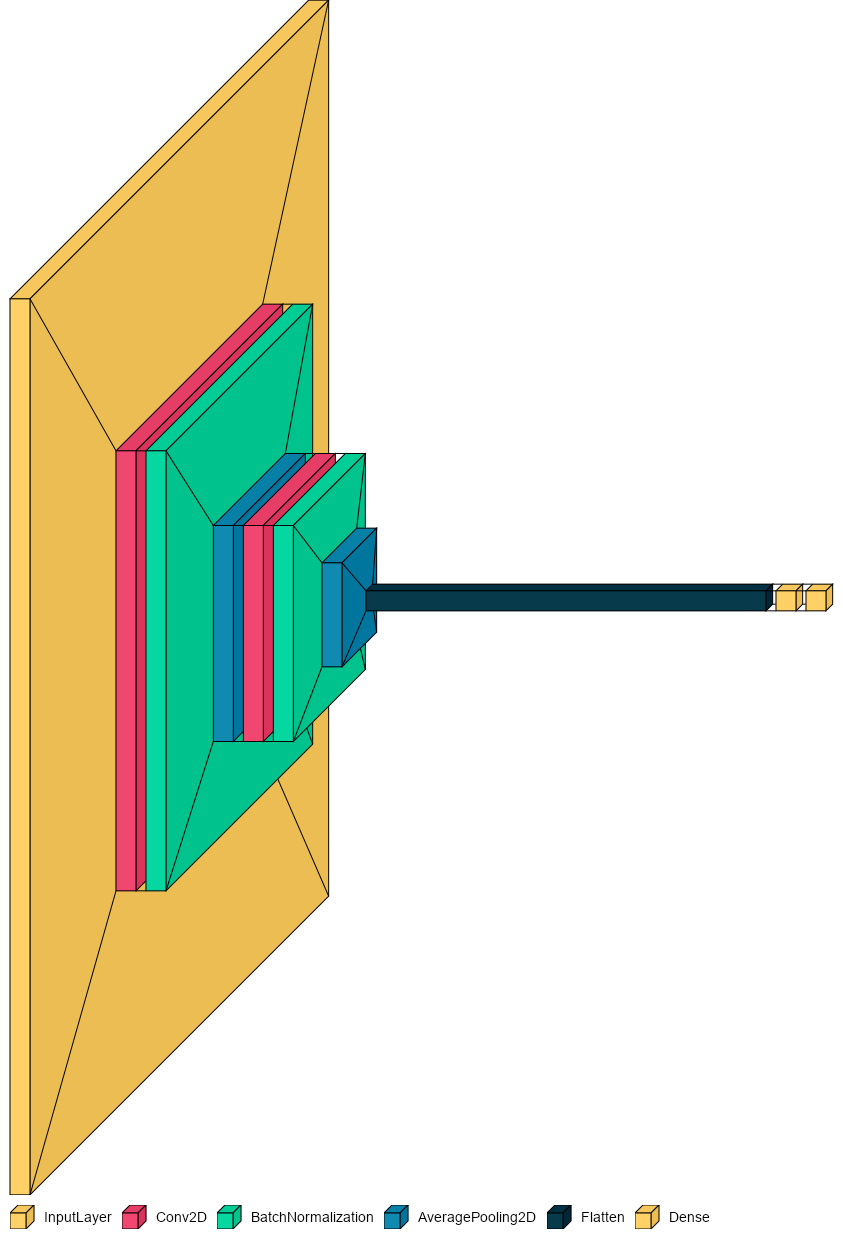

In [ ]:
#!pip install visualkeras
import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

model = get_model()

visualkeras.layered_view(model, color_map=color_map)
from PIL import ImageFont

font = ImageFont.load_default()  # using comic sans is strictly prohibited!
font_type = ImageFont.truetype("arial.ttf", 14)
visualkeras.layered_view(model, legend=True, font=font_type)  # font is optional!

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

kf = KFold(n_splits = 8)
fold_var = 1

In [ ]:
VALIDATION_R2 = []
VALIDATION_LOSS = []
VALIDATION_MSE = []
VALIDATION_MAE = []

save_dir = 'saved_models/'

In [ ]:
for train_index, val_index in kf.split(np.zeros(Y.shape[0]),Y):
  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_images = train_generator.flow_from_dataframe(training_data,
                                                 x_col = "Filepath", y_col = "Turbidity",
                                                 target_size=(224, 224), color_mode='rgb',
                                                 class_mode = "raw", shuffle = True)
  val_images  = train_generator.flow_from_dataframe(validation_data,
                                                  x_col = "Filepath", y_col = "Turbidity",
                                                  target_size=(224, 224), color_mode='rgb',
                                                  class_mode = "raw", shuffle = True)
	
	# CREATE NEW MODEL
  model = get_model()
	# COMPILE NEW MODEL
  opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])
	
	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
  history = model.fit(train_images, epochs=100,
                      callbacks=callbacks_list,
                      validation_data=val_images)
	
	# LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights("saved_models/NewNet_"+str(fold_var)+".h5")

  results = model.evaluate(val_images)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_R2.append(results['R2'])
  VALIDATION_MAE.append(results['mae'])
  VALIDATION_MSE.append(results['mse'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

Found 424 validated image filenames.
Found 61 validated image filenames.
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 43.3497 - mae: 43.8477 - mse: 2960.7371 - R2: -1.1382
Epoch 1: val_loss improved from inf to 559.71991, saving model to saved_models/NewNet_1.h5
14/14 [==============================] - 129s 9s/step - loss: 43.3497 - mae: 43.8477 - mse: 2960.7371 - R2: -1.1382 - val_loss: 559.7199 - val_mae: 560.2199 - val_mse: 315029.8125 - val_R2: -273.2252
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 20.5815 - mae: 21.0792 - mse: 938.4003 - R2: 0.3223 
Epoch 2: val_loss improved from 559.71991 to 179.83421, saving model to saved_models/NewNet_1.h5
14/14 [==============================] - 10s 698ms/step - loss: 20.5815 - mae: 21.0792 - mse: 938.4003 - R2: 0.3223 - val_loss: 179.8342 - val_mae: 180.3342 - val_mse: 32913.3984 - val_R2: -27.6503
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 11.1656 - mae: 11.6608 - ms

In [ ]:
model = get_model()
model.load_weights("saved_models/NewNet_8.h5")

In [ ]:
model = get_model()
model.load_weights("/content/gdrive/MyDrive/Hasil_Train/Training/0DEG-NewNet-8Fold/NewNet_8.h5")
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

In [ ]:
print(VALIDATION_LOSS)
print(VALIDATION_R2)

[3.430809259414673, 5.53158712387085, 3.9200286865234375, 3.906599760055542, 3.813234329223633, 3.7740259170532227, 4.951094150543213, 2.945373058319092]
[0.9789895415306091, 0.9487677812576294, 0.9765193462371826, 0.9753780961036682, 0.9787654280662537, 0.9780034422874451, 0.9706982970237732, 0.9862776398658752]


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 485 validated image filenames.
Found 54 validated image filenames.


In [ ]:
val_images = test_generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 539 validated image filenames.


In [ ]:
train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

val_pred = np.squeeze(model.predict(val_images))
val_true = val_images.labels
val_residuals = val_true - val_pred

In [ ]:
from sklearn.metrics import r2_score as r2
r2_train = r2(train_true,train_pred)
r2_test = r2(test_true,test_pred)
r2_val = r2(val_true,val_pred)
print(round(r2_train,3))
print(round(r2_test,3))
print(round(r2_val,3))

0.985
0.976
0.984


In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
MAE_train = MAE(train_true,train_pred)
MAE_test = MAE(test_true,test_pred)
MAE_val = MAE(val_true,val_pred)
print(round(MAE_train,3))
print(round(MAE_test,3))
print(round(MAE_val,3))

3.391
3.877
3.44


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
MSE_train = MSE(train_true,train_pred)
MSE_test = MSE(test_true,test_pred)
MSE_val = MSE(val_true,val_pred)
print(round(MSE_train,3))
print(round(MSE_test,3))
print(round(MSE_val,3))

20.783
23.071
20.627


In [ ]:
table = pd.DataFrame()
table['True'] = test_true.tolist()
table['Prediksi'] = test_pred.tolist()
print(table)

In [ ]:
table.sort_values(['True', 'Prediksi'], ascending=[True, False], inplace=True)
print(table)
table.to_excel('output1.xlsx') 

In [ ]:
fold = '8'

if not os.path.exists(f'saved_model/{fold}'):
  os.makedirs(f'saved_model/{fold}')

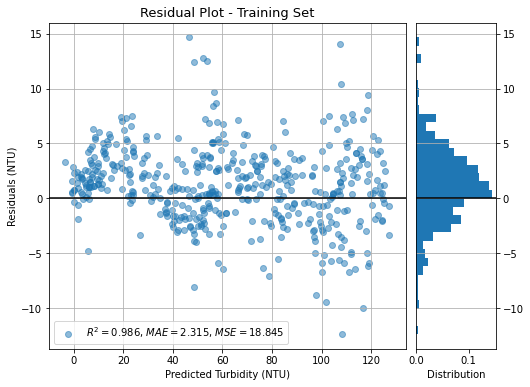

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(train_pred,train_residuals, label=f'$R^2=${0.986}, $MAE=${2.315}, $MSE=${18.845}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Training Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'saved_model/{fold}/ResidualPlotTrain_Fold{fold}.png', dpi=300)
plt.show()

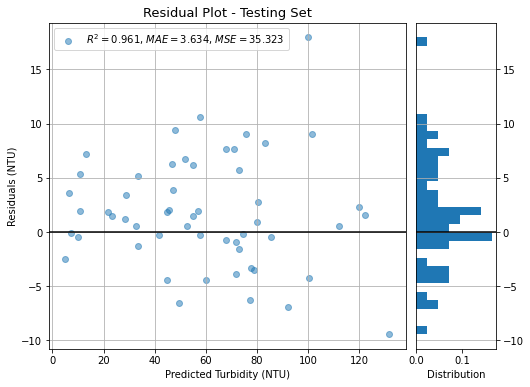

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(test_pred,test_residuals, label=f'$R^2=${0.961}, $MAE=${3.634}, $MSE=${35.323}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Testing Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(test_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'saved_model/{fold}/ResidualPlotTest_Fold{fold}.png', dpi=300)
plt.show()

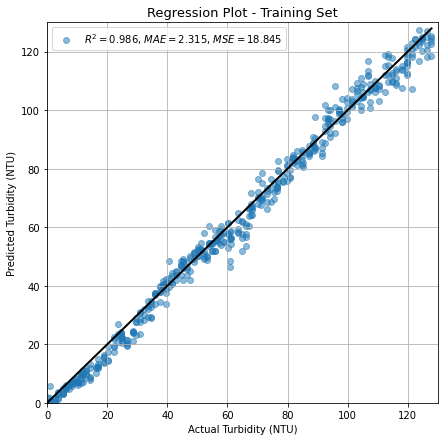

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(train_true,train_pred, label=f'$R^2=${0.986}, $MAE=${2.315}, $MSE=${18.845}', color='tab:blue', alpha=0.5)
theta = np.polyfit(train_true, train_pred, 1)
y_line = theta[1] + theta[0] * train_true
ax.plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Training Set', fontsize=13)
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'saved_model/{fold}/RegressionPlotTrain_Fold{fold}.png', dpi=300)
plt.show()

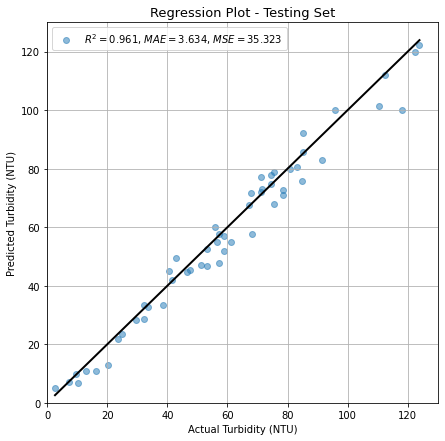

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(test_true,test_pred, label=f'$R^2=${0.961}, $MAE=${3.634}, $MSE=${35.323}', color='tab:blue', alpha=0.5)
theta2 = np.polyfit(test_true, test_pred, 1)
y_line2 = theta2[1] + theta2[0] * test_true
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Testing Set', fontsize=13)
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'saved_model/{fold}/RegressionPlotTest_Fold{fold}.png', dpi=300)
plt.show()

Grafik

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/90DEG-NewNet-8Fold"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_model/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/90DEG-NewNet-8Fold-AvgPooling-ReLu"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_models/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
